In [46]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Conv1D, Dropout, Dense
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.utils import to_categorical
import os
import gzip

In [47]:
# Rutas de los conjuntos de datos
# Obtener el directorio actual del notebook
current_dir = os.getcwd()

# Dataset reducido, contiene las primeras 1500 proteinas del dataset cullpdb+profile_6133.npy, se incluyó una versión reducida por los límites de almacenamiento impuestos por la plataforma github.
# La arquitectura del modelo presentado se entrenó con el dataset original, si se utiliza el dataset reducido el modelo es susceptible al sobreajuste.
dataset_path = os.path.join(current_dir, 'data', 'cullpdb+profile_6133_reduced_1500.npy.gz')
cb513_path = os.path.join(current_dir, 'data', 'cb513+profile_split1.npy.gz')

# Ruta al dataset original, no fue incluido en el repositorio
#dataset_path = os.path.join(current_dir, 'data', 'cullpdb+profile_6133.npy.gz')

# Parámetros del modelo
sequence_len = 700
amino_acid_residues = 21
num_classes = 3
class_labels = ['H', 'E', 'C']  # Tres categorías principales
total_features = 57

In [48]:
"""
Los datasets en su forma original (N proteínas x k características), y se les da la forma (N proteínas x 700 aminoácidos x 57 características).
Las 57 características son:
[0,22): resíduos de aminoácidos, en el orden 'A', 'C', 'E', 'D', 'G', 'F', 'I', 'H', 'K', 'M', 'L', 'N', 'Q', 'P', 'S', 'R', 'T', 'W', 'V', 'Y', 'X','NoSeq'
[22,31): etiquetas de la estructura secundaria: 'L', 'B', 'E', 'G', 'I', 'H', 'S', 'T','NoSeq'
[31,33): N- y C- terminales
[33,35): accesibilidad al solvente relativa y absoluta
[35,57): perfiles de las sequencias. el orden de los aminoacídos aquí es ACDEFGHIKLMNPQRSTVWXY
la última característica de los aminoacídos y de las etiquetas de la estructura secundaria marcan el fin de la secuencia de proteinas. 
"""


"\nLos datasets en su forma original (N proteínas x k características), y se les da la forma (N proteínas x 700 aminoácidos x 57 características).\nLas 57 características son:\n[0,22): resíduos de aminoácidos, en el orden 'A', 'C', 'E', 'D', 'G', 'F', 'I', 'H', 'K', 'M', 'L', 'N', 'Q', 'P', 'S', 'R', 'T', 'W', 'V', 'Y', 'X','NoSeq'\n[22,31): etiquetas de la estructura secundaria: 'L', 'B', 'E', 'G', 'I', 'H', 'S', 'T','NoSeq'\n[31,33): N- y C- terminales\n[33,35): accesibilidad al solvente relativa y absoluta\n[35,57): perfiles de las sequencias. el orden de los aminoacídos aquí es ACDEFGHIKLMNPQRSTVWXY\nla última característica de los aminoacídos y de las etiquetas de la estructura secundaria marcan el fin de la secuencia de proteinas. \n"

In [49]:
# Función para mapear etiquetas a tres categorías
def map_to_three_classes(labels):
    # Mapear a las tres clases principales: H (Hélix), E (Hoja), C (Coil)
    three_class_labels = np.zeros_like(labels)
    # H (Helix) -> H (H)
    three_class_labels[:, :, 0] = labels[:, :, 2] + labels[:, :, 3] + labels[:, :, 4]
    # E (Sheet) -> E (E)
    three_class_labels[:, :, 1] = labels[:, :, 1] + labels[:, :, 5]
    # C (Coil) -> C (C)
    three_class_labels[:, :, 2] = labels[:, :, 0] + labels[:, :, 6] + labels[:, :, 7]
    return three_class_labels

In [50]:
# Función para cargar el conjunto de datos desde un archivo .gz
def get_dataset(path):
    with gzip.open(path, 'rb') as f:
        ds = np.load(f, allow_pickle=True)
        ds = np.reshape(ds, (ds.shape[0], sequence_len, total_features))
        ret = np.zeros((ds.shape[0], ds.shape[1], amino_acid_residues + 8))
        ret[:, :, 0:amino_acid_residues] = ds[:, :, 35:56]
        ret[:, :, amino_acid_residues:] = ds[:, :, amino_acid_residues + 1:amino_acid_residues + 1 + 8]
        ret[:, :, amino_acid_residues:] = map_to_three_classes(ret[:, :, amino_acid_residues:])  # Mapear etiquetas
    return ret

def split_with_shuffle(Dataset, seed=None):
    np.random.seed(seed)
    np.random.shuffle(Dataset)
    train_split = int(Dataset.shape[0] * 0.8)
    test_val_split = int(Dataset.shape[0] * 0.1)
    Train = Dataset[0:train_split, :, :]
    Test = Dataset[train_split:train_split + test_val_split, :, :]
    Validation = Dataset[train_split + test_val_split:, :, :]
    return Train, Test, Validation

# Función para dividir el conjunto de datos como en el paper
# def split_like_paper(dataset):
#     Train = dataset[:5600]
#     Test = dataset[5600:5877]
#     Validation = dataset[5877:]
#     return Train, Test, Validation

# Función para obtener los datos y las etiquetas
def get_data_labels(dataset):
    X = dataset[:, :, :amino_acid_residues]
    Y = dataset[:, :, amino_acid_residues:amino_acid_residues + num_classes]
    return X, Y

In [51]:
# Función para crear el modelo CNN
def CNN_model():
    model = Sequential([
        Conv1D(96, 7, padding='same', activation='relu', input_shape=(sequence_len, amino_acid_residues), kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Conv1D(num_classes, 11, padding='same', activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.00005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'mae'])
    model.summary()
    return model

In [52]:
# Cargar los datos
dataset = get_dataset(dataset_path)
CB513_X, CB513_Y = get_data_labels(get_dataset(cb513_path))

# Dividir los datos
#D_train, D_test, D_val = split_like_paper(dataset)
D_train, D_test, D_val = split_with_shuffle(dataset, 1)
X_train, Y_train = get_data_labels(D_train)
X_test, Y_test = get_data_labels(D_test)
X_val, Y_val = get_data_labels(D_val)

In [53]:
# Función para calcular la precisión Q3
def Q3_accuracy(real, pred):
    mask = np.sum(real, axis=-1) > 0
    correct = np.sum((np.argmax(real, axis=-1) == np.argmax(pred, axis=-1)) & mask)
    total = np.sum(mask)
    return correct / total

In [54]:
# Crear el modelo CNN
net = CNN_model()

# Callbacks
lr_scheduler = LearningRateScheduler(lambda epoch: 0.00005 * (0.1 ** (epoch // 10)))
filepath = os.path.join(current_dir, 'results', 'Whole_CullPDB_Q3-best.keras')
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [lr_scheduler, checkpoint]

# Entrenar el modelo
history = net.fit(X_train, Y_train, epochs=20, batch_size=128, shuffle=True,
                  validation_data=(X_val, Y_val), callbacks=callbacks_list)

# Evaluar el modelo en los datos de prueba y CB513
test_accuracy = Q3_accuracy(Y_test, net.predict(X_test))
cb513_accuracy = Q3_accuracy(CB513_Y, net.predict(CB513_X))
print("\n\nQ3 accuracy on Test Dataset: {:.4f}".format(test_accuracy))
print("Q3 accuracy on CB513 Dataset: {:.4f}\n\n".format(cb513_accuracy))

c:\Users\DAVID\anaconda3\envs\ML_tensorflow\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 700, 96)        │        14,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 700, 96)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 700, 64)        │        30,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 700, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 700, 3)         │         2,115 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,107 (184.01 KB)

 Trainable params: 47,107 (184.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.3073 - loss: 0.4420 - mae: 0.3657
Epoch 1: val_accuracy improved from -inf to 0.10850, saving model to c:\Users\DAVID\ML_pssp_David_Ortega\results\Whole_CullPDB_Q3-best.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 357ms/step - accuracy: 0.2957 - loss: 0.4421 - mae: 0.3657 - val_accuracy: 0.1085 - val_loss: 0.4286 - val_mae: 0.3658 - learning_rate: 5.0000e-05
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.1110 - loss: 0.4380 - mae: 0.3649
Epoch 2: val_accuracy improved from 0.10850 to 0.11831, saving model to c:\Users\DAVID\ML_pssp_David_Ortega\results\Whole_CullPDB_Q3-best.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 388ms/step - accuracy: 0.1110 - loss: 0.4379 - mae: 0.3649 - val_accuracy: 0.1183 - val_loss: 0.4245 - val_mae: 0.3649 - learning_rate: 5.0000e-05
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.1146 - loss: 0.4339 - mae: 0.3642
Epoch 3: val_accuracy improved from 0.11831 to 0.12424, savin

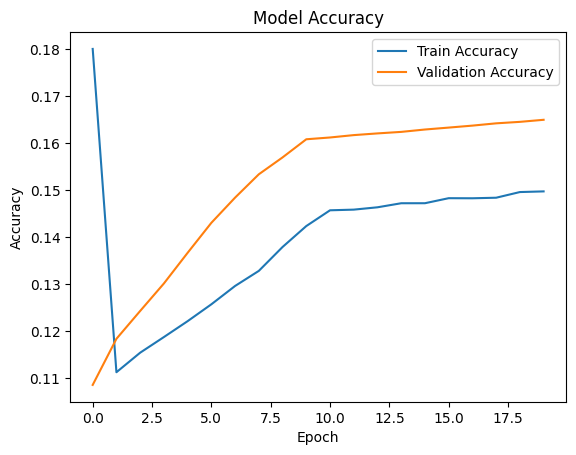

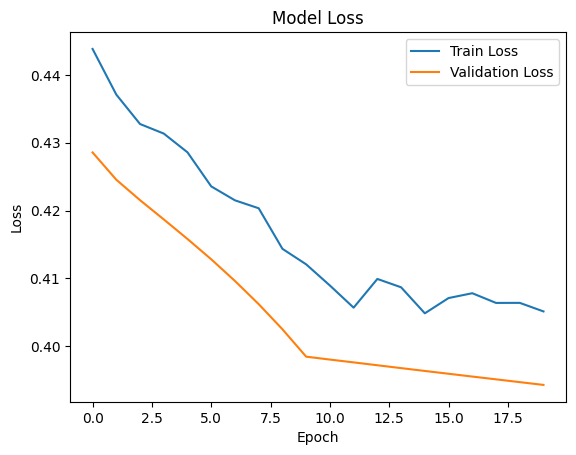

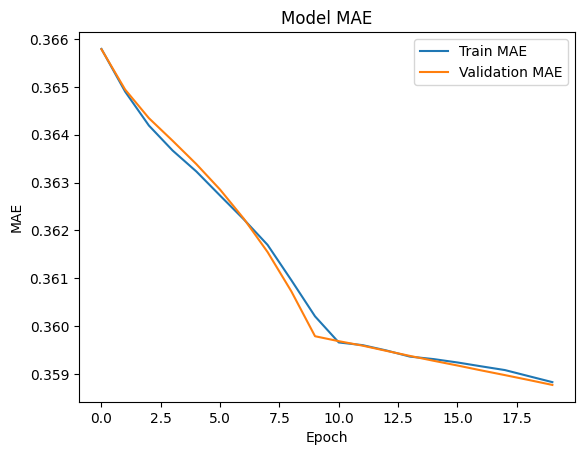

In [55]:
# Graficar historias de entrenamiento
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [56]:
def plot_confusion_matrix(y_true, y_pred, classes):
    y_true_labels = np.argmax(y_true, axis=-1).flatten()
    y_pred_labels = np.argmax(y_pred, axis=-1).flatten()
    
    # Filtrar etiquetas válidas
    valid_idx = y_true_labels != 8  # Aquí 8 es la etiqueta de padding, ajustar según el caso
    y_true_labels = y_true_labels[valid_idx]
    y_pred_labels = y_pred_labels[valid_idx]

    cm = confusion_matrix(y_true_labels, y_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


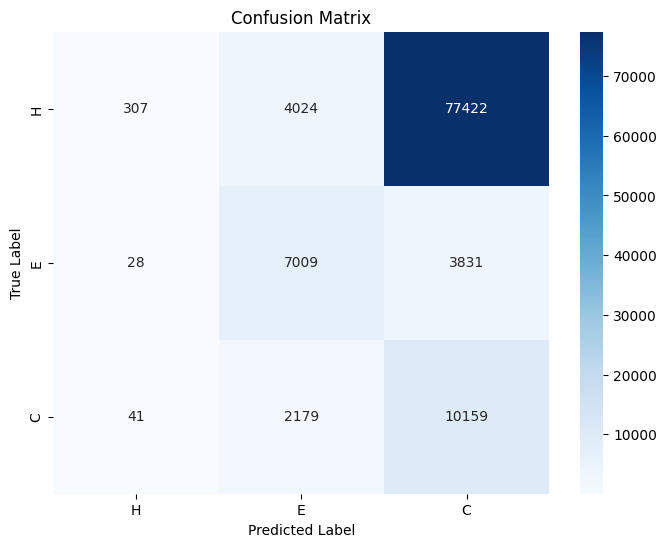

In [57]:
plot_confusion_matrix(Y_test, net.predict(X_test), classes=class_labels)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


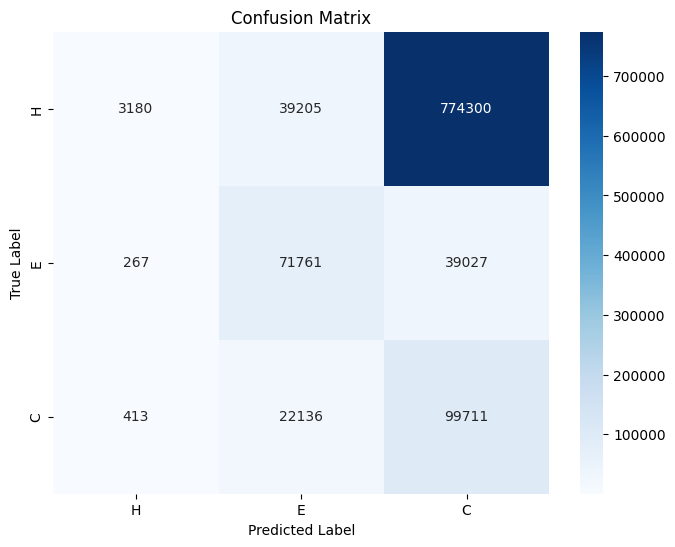

In [58]:
plot_confusion_matrix(CB513_Y, net.predict(CB513_X), classes=class_labels)

In [59]:
#net.save('C:\\Users\\DAVID\\ML_pssp\\model\\Whole_CullPDB_Q3_CB513_0.70.keras')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Q8 accuracy on Test Dataset: 0.7115
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
Q3 accuracy on CB513 Dataset: 0.7193




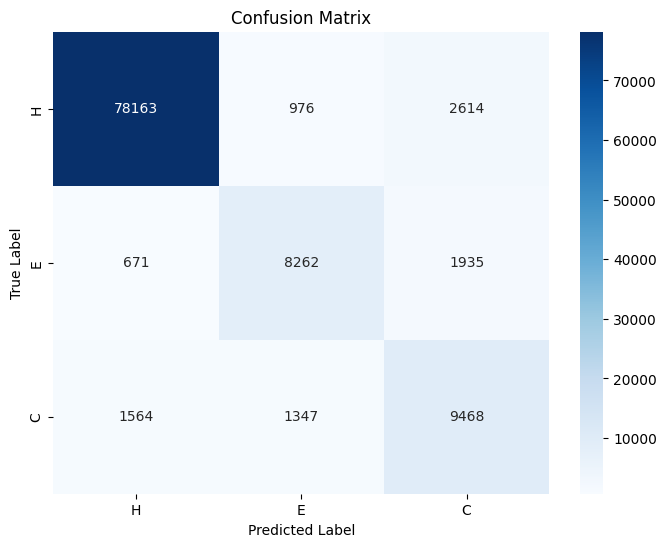

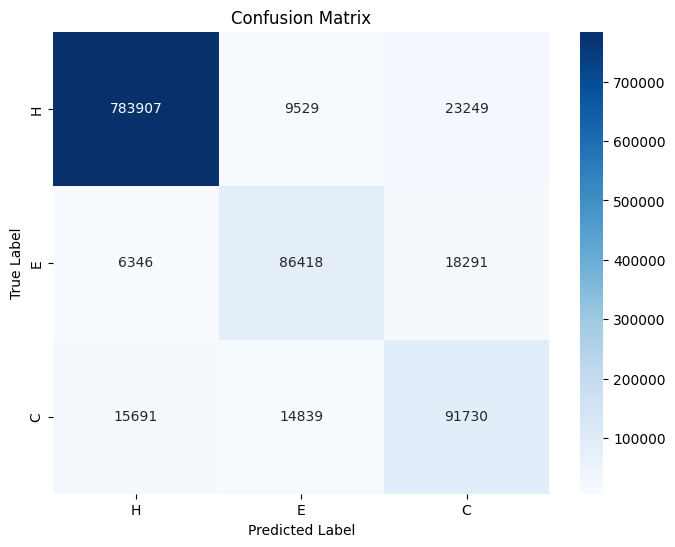

In [60]:
from keras.models import load_model

# Cargar el mejor modelo, entrenado con el dataset cullpdb+profile_6133
net_val = load_model(os.path.join(current_dir, 'best_models', 'Whole_CullPDB_Q3_CB513_0.70.keras'))

# Realizar predicciones en el conjunto de prueba
predictions_test = net_val.predict(X_test)
test_accuracy = Q3_accuracy(Y_test, predictions_test)
print("\n\nQ8 accuracy on Test Dataset: {:.4f}".format(test_accuracy))

# Realizar predicciones en CB513
predictions_cb513 = net_val.predict(CB513_X)
cb513_accuracy = Q3_accuracy(CB513_Y, predictions_cb513)
print("Q3 accuracy on CB513 Dataset: {:.4f}\n\n".format(cb513_accuracy))

# Matriz de confusión para el conjunto de prueba
plot_confusion_matrix(Y_test, predictions_test, class_labels)

# Matriz de confusión para CB513
plot_confusion_matrix(CB513_Y, predictions_cb513, class_labels)